# Fine Tune

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

import torch
import torch.utils.data
from torch.utils.data import DataLoader, TensorDataset

import tqdm as tqdm

## Prepare Dataset

In [8]:
mbti_df = pd.read_csv('../processed/all_data_3.csv')

In [9]:
mbti_df

,Unnamed: 0,type,tweet
0,0,ISFJ,"Mindhunter, Broadchurch, The Sinner, Orphan Bl..."
1,1,ISFJ,Tinder has your health in mind.
2,2,ISFJ,5 of 5 stars to Pretty Face by Lucy Parker
3,3,ISFJ,Outstanding faculty from and more at Winter Co...
4,4,ISFJ,"Using pray and wait on God, can be a means of ..."
...,...,...,...
106322,106322,ESTP,This is so legit holy shit lol I work in rando...
106323,106323,ESTP,Same here When Im in a group Im fairly quiet u...
106324,106324,ESTJ,Im more worried about the idea that we are sla...
106325,106325,ESTP,Believing you dont have ethics is still an eth...


In [10]:
mbti_df = mbti_df.drop(columns=['Unnamed: 0'])

### Consider only posts with length < 32 words

In [11]:
mbti_df = mbti_df[mbti_df['tweet'].str.split().str.len() < 32]

In [12]:
mbti_df

,type,tweet
0,ISFJ,"Mindhunter, Broadchurch, The Sinner, Orphan Bl..."
1,ISFJ,Tinder has your health in mind.
2,ISFJ,5 of 5 stars to Pretty Face by Lucy Parker
3,ISFJ,Outstanding faculty from and more at Winter Co...
4,ISFJ,"Using pray and wait on God, can be a means of ..."
...,...,...
106313,ESTP,True I do end up the mentor but I feel like Yo...
106321,ESFP,LOL and thats why I got sort of mad because th...
106322,ESTP,This is so legit holy shit lol I work in rando...
106324,ESTJ,Im more worried about the idea that we are sla...


C:\Users\fizuf\AppData\Local\Temp\ipykernel_9664\4277072644.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=mbti_df_grouped, x='type', y='n_posts', palette='husl')


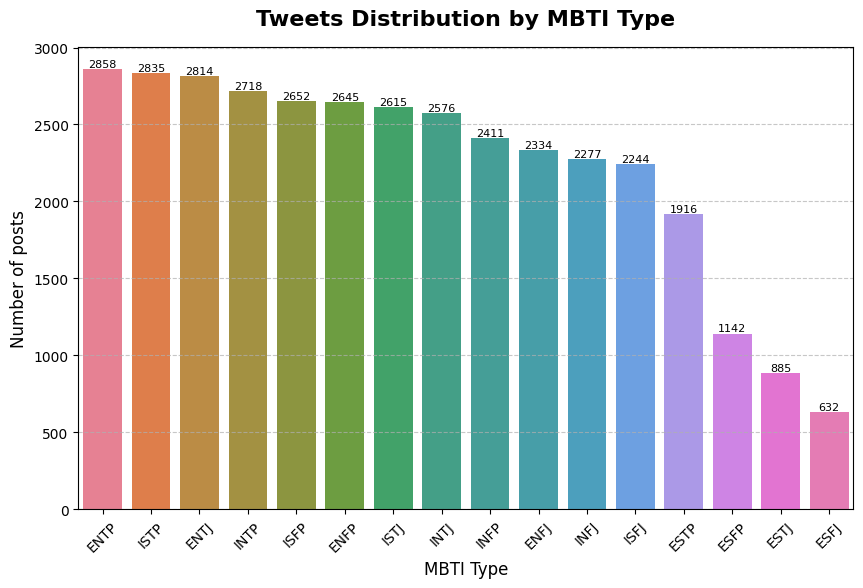

In [13]:
mbti_df_grouped = mbti_df.groupby('type').size().reset_index(name='n_posts')
mbti_df_grouped = mbti_df_grouped.sort_values(by='n_posts', ascending=False)
mbti_df_grouped.columns = ['type', 'n_posts']

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=mbti_df_grouped, x='type', y='n_posts', palette='husl')

# Add annotations (number of users above each bar)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=8, color='black')

plt.title('Tweets Distribution by MBTI Type', fontsize=16, fontweight='bold', pad=16)
plt.xlabel('MBTI Type', fontsize=12)
plt.ylabel('Number of posts', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [14]:
mbti_labels_dict = {
    'ENFJ': 0,
    'ENFP': 1,
    'ENTJ': 2,
    'ENTP': 3,
    'ESFJ': 4,
    'ESFP': 5,
    'ESTJ': 6,
    'ESTP': 7,
    'INFJ': 8,
    'INFP': 9,
    'INTJ': 10,
    'INTP': 11,
    'ISFJ': 12,
    'ISFP': 13,
    'ISTJ': 14,
    'ISTP': 15,
}

### Split datasets

In [15]:
X = mbti_df['tweet']
y = mbti_df['type']

y = y.map(mbti_labels_dict)

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cpu


### Fine Tune BERT

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=16)  # 16 labels for MBTI
model.config.hidden_dropout_prob = 0.3

In [ ]:
inputs = tokenizer(X.tolist(), padding=True, truncation=True, max_length=32, return_tensors='pt')
labels = torch.tensor(y.values) 

train_dataset = torch.utils.data.TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)

train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.3)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)

c:\Users\fizuf\anaconda3\envs\vidovax-env\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10

losses = []
acc = []
prec = []
recalls = []
f1score = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    for batch in train_dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        # Calculate loss
        loss = criterion(logits, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track loss
        running_loss += loss.item()
        
        # Track predictions and labels
        preds = logits.argmax(dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    avg_loss = running_loss / len(train_dataloader)

    losses.append(avg_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}")
    
    # Calculate metrics (accuracy, precision, recall, F1-score)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    acc.append(accuracy)
    prec.append(precision)
    recalls.append(recall)
    f1score.append(f1)

    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\fizuf\anaconda3\envs\vidovax-env\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10, Loss: 2.6959244331541283
Accuracy: 0.1003, Precision: 0.0941, Recall: 0.1003, F1-Score: 0.0879


c:\Users\fizuf\anaconda3\envs\vidovax-env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/10, Loss: 2.584782879426118
Accuracy: 0.1508, Precision: 0.1424, Recall: 0.1508, F1-Score: 0.1377
Epoch 3/10, Loss: 2.4095091639723445
Accuracy: 0.2189, Precision: 0.2141, Recall: 0.2189, F1-Score: 0.2064


c:\Users\fizuf\anaconda3\envs\vidovax-env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/10, Loss: 2.1344326783574945
Accuracy: 0.3156, Precision: 0.3170, Recall: 0.3156, F1-Score: 0.3040
Epoch 5/10, Loss: 1.7745517201166225
Accuracy: 0.4342, Precision: 0.4316, Recall: 0.4342, F1-Score: 0.4229
Epoch 6/10, Loss: 1.3988858321944975
Accuracy: 0.5548, Precision: 0.5517, Recall: 0.5548, F1-Score: 0.5449
Epoch 7/10, Loss: 1.0591210239497433
Accuracy: 0.6670, Precision: 0.6623, Recall: 0.6670, F1-Score: 0.6597
Epoch 8/10, Loss: 0.7762649228609619
Accuracy: 0.7585, Precision: 0.7558, Recall: 0.7585, F1-Score: 0.7536
Epoch 9/10, Loss: 0.5765125155401031
Accuracy: 0.8196, Precision: 0.8172, Recall: 0.8196, F1-Score: 0.8163
Epoch 10/10, Loss: 0.42083878574801903
Accuracy: 0.8703, Precision: 0.8691, Recall: 0.8703, F1-Score: 0.8687


### Loss

### Accuracy, precision, recall, and f1-score

In [45]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(all_preds, all_labels))


              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1665
           1       0.85      0.85      0.85      1848
           2       0.91      0.91      0.91      1940
           3       0.93      0.91      0.92      2050
           4       0.40      0.73      0.52       253
           5       0.71      0.81      0.75       699
           6       0.78      0.71      0.74       678
           7       0.84      0.83      0.83      1378
           8       0.84      0.84      0.84      1591
           9       0.89      0.89      0.89      1707
          10       0.88      0.88      0.88      1808
          11       0.92      0.89      0.91      1990
          12       0.90      0.89      0.89      1553
          13       0.89      0.88      0.89      1895
          14       0.91      0.89      0.90      1834
          15       0.89      0.89      0.89      1998

    accuracy                           0.87     24887
   macro avg       0.84   

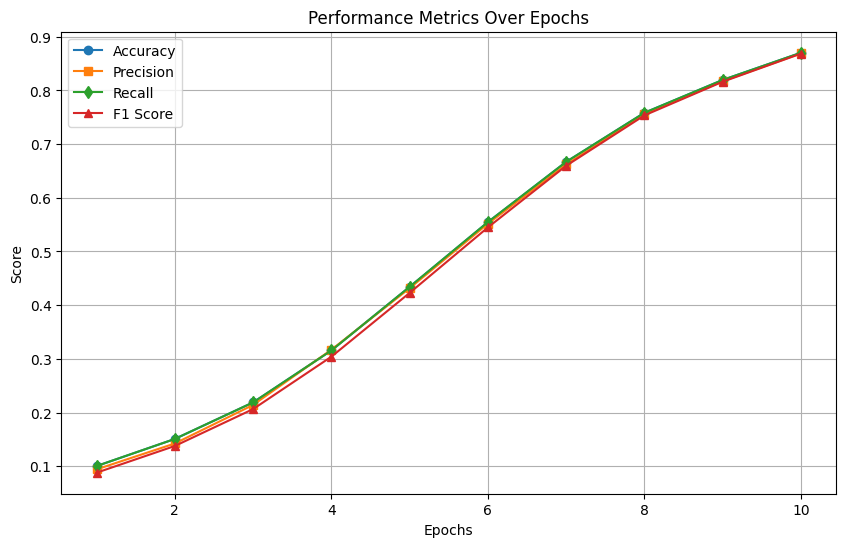

In [46]:
epochs = range(1, len(acc) + 1)

# Plotting the metrics
plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, label='Accuracy', marker='o')
plt.plot(epochs, prec, label='Precision', marker='s')
plt.plot(epochs, recalls, label='Recall', marker='d')
plt.plot(epochs, f1score, label='F1 Score', marker='^')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Performance Metrics Over Epochs')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

## Evaluation

In [2]:
import joblib 

model = joblib.load('data/model_2.joblib')
tokenizer = joblib.load('data/tokenizer_2.joblib')

c:\Users\fizuf\anaconda3\envs\vidovax-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
import torch

model.eval()  # Set model to evaluation mode

val_preds = []
val_labels = []
all_attentions = []

with torch.no_grad():
    for batch in val_dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, output_attentions=True)
        attentions = outputs.attentions
        all_attentions.append(attentions)
        logits = outputs.logits
        preds = logits.argmax(dim=-1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())
                        
    # Validation metrics
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(val_labels, val_preds, average='weighted')

    print(f"Testing - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1-Score: {val_f1:.4f}")

# Print classification report using val_preds and val_labels
print(classification_report(val_labels, val_preds))


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Testing - Accuracy: 0.7185, Precision: 0.7295, Recall: 0.7185, F1-Score: 0.7200
              precision    recall  f1-score   support

           0       0.73      0.73      0.73       677
           1       0.68      0.75      0.71       854
           2       0.79      0.71      0.75       882
           3       0.84      0.73      0.78       849
           4       0.70      0.41      0.52       186
           5       0.74      0.66      0.70       361
           6       0.64      0.69      0.66       256
           7       0.78      0.72      0.75       589
           8       0.77      0.69      0.73       691
           9       0.54      0.79      0.64       688
          10       0.64      0.72      0.68       747
          11       0.72      0.74      0.73       802
          12       0.77      0.72      0.75       686
          13       0.66      0.75      0.71       735
          14       0.81      0.70      0.75       819
          15       0.75      0.71      0.73       845

